# COURSE: A deep understanding of deep learning
## SECTION: FFNs
### LECTURE: Distributions of weights pre- and post-learning
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202401

In [2]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [3]:
# import dataset (comes with colab!)
# data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# import dataset from torchvision
import torchvision.datasets as datasets

mnist_train = datasets.MNIST(root='./data', train=True, download=True)
mnist_test = datasets.MNIST(root='./data', train=False, download=True)

train_data = mnist_train.data
train_labels = mnist_train.targets
test_data = mnist_test.data
test_labels = mnist_test.targets

# reshape data to 2D tensor
train_data = train_data.reshape(-1, 28*28).float()
test_data = test_data.reshape(-1, 28*28).float()

labels = torch.cat((train_labels, test_labels), dim=0)
data = torch.cat((train_data, test_data), dim=0)

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data.numpy())

labelsPy = labels.numpy()
dataPy = data.numpy()
dataNormPy = dataNorm.numpy()



# Create train/test groups using DataLoader

In [4]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)


# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

/tmp/ipykernel_1209922/646352733.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataT   = torch.tensor( dataNorm ).float()
/tmp/ipykernel_1209922/646352733.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labelsT = torch.tensor( labels ).long()


# Create the DL model

In [5]:
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)
      
      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return self.output(x)
  
  # create the model instance
  net = mnistNet()
  
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer

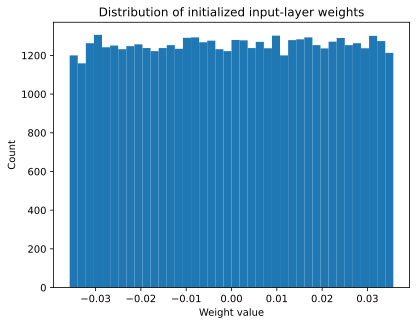

In [6]:
### exploring the "innards" of the model

# create a temp model to explore
net = createTheMNISTNet()[0]

# summary of the entire model
# print('Summary of model:')
# print(net)
# print(' ')

# # explore one of the layers
# print('Summary of input layer:')
# print( vars(net.input) )
# print(' ')

# check out the matrix of weights
# print('Input layer weights:')
# print( net.input.weight.shape )
# print( net.input.weight )
# print(' ')

# # finally, extract the weights and make a histogram
w = net.input.weight.detach().flatten()
plt.hist(w,40)
plt.xlabel('Weight value')
plt.ylabel('Count')
plt.title('Distribution of initialized input-layer weights')
plt.show()

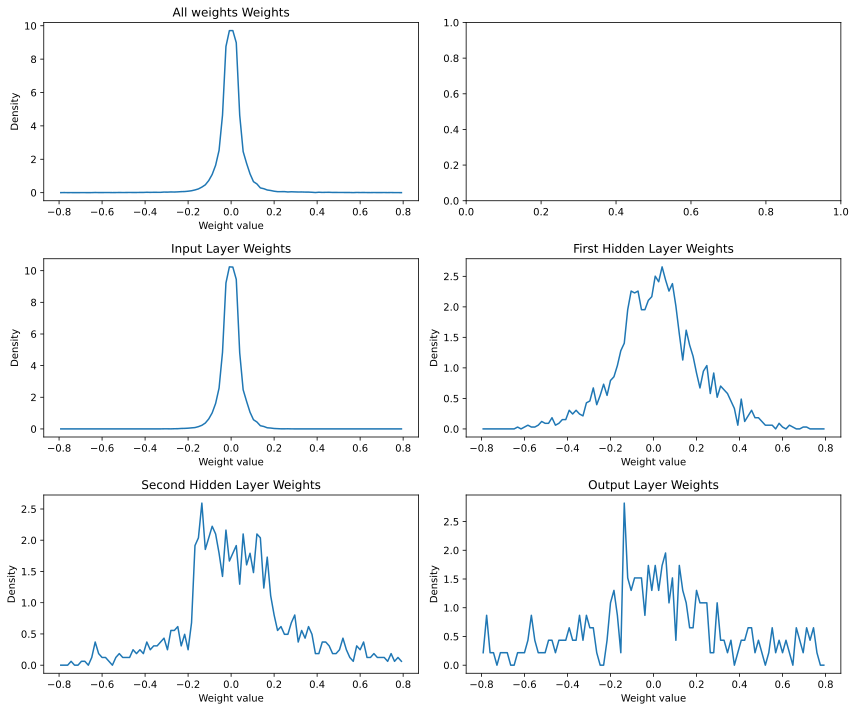

In [28]:
# a function that returns a histogram of all weights (across all layers)

def weightsHistogram(net):

  # initialize weight vector
  W = np.array([])
  
  # concatenate each set of weights
  for layer in net.parameters():
    W = np.concatenate((W,layer.detach().flatten().numpy() ))

  # compute their histogram (note: range is hard-coded)
  histy,histx = np.histogram(W,bins=np.linspace(-.8,.8,101),density=True)
  histx = (histx[1:]+histx[:-1])/2
  return histx,histy

def weightsHistogramUpgraded(net):
  inputW = net.input.weight.detach().flatten().numpy()
  fc1W = net.fc1.weight.detach().flatten().numpy()
  fc2W = net.fc2.weight.detach().flatten().numpy()
  outputW = net.output.weight.detach().flatten().numpy()

  histyInput,histxInput = np.histogram(inputW,bins=np.linspace(-.8,.8,101),density=True)
  histyfc1,histxfc1 = np.histogram(fc1W,bins=np.linspace(-.8,.8,101),density=True)
  histyfc2,histxfc2 = np.histogram(fc2W,bins=np.linspace(-.8,.8,101),density=True)
  histyOutput,histxOutput = np.histogram(outputW,bins=np.linspace(-.8,.8,101),density=True)

  histxInput = (histxInput[1:]+histxInput[:-1])/2
  histxfc1 = (histxfc1[1:]+histxfc1[:-1])/2
  histxfc2 = (histxfc2[1:]+histxfc2[:-1])/2
  histxOutput = (histxOutput[1:]+histxOutput[:-1])/2

  return histxInput,histyInput,histxfc1,histyfc1,histxfc2,histyfc2,histxOutput,histyOutput

# test it!
histx,histy = weightsHistogram(net)
histxInput,histyInput,histxfc1,histyfc1,histxfc2,histyfc2,histxOutput,histyOutput = weightsHistogramUpgraded(net)

fig, axs = plt.subplots(3, 2, figsize=(12, 10))

axs[0, 0].plot(histx, histy)
axs[0, 0].set_title('All weights Weights')
axs[0, 0].set_xlabel('Weight value')
axs[0, 0].set_ylabel('Density')

axs[1, 0].plot(histxInput, histyInput)
axs[1, 0].set_title('Input Layer Weights')
axs[1, 0].set_xlabel('Weight value')
axs[1, 0].set_ylabel('Density')

axs[1, 1].plot(histxfc1, histyfc1)
axs[1, 1].set_title('First Hidden Layer Weights')
axs[1, 1].set_xlabel('Weight value')
axs[1, 1].set_ylabel('Density')

axs[2, 0].plot(histxfc2, histyfc2)
axs[2, 0].set_title('Second Hidden Layer Weights')
axs[2, 0].set_xlabel('Weight value')
axs[2, 0].set_ylabel('Density')

axs[2, 1].plot(histxOutput, histyOutput)
axs[2, 1].set_title('Output Layer Weights')
axs[2, 1].set_xlabel('Weight value')
axs[2, 1].set_ylabel('Density')

plt.tight_layout()
plt.show()

# Create a function that trains the model

In [29]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 100
  
  # create a new model
  net,lossfun,optimizer = createTheMNISTNet()

  # initialize losses and accuracies
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []

  # initialize histogram variables
  histx       = np.zeros((numepochs,100))
  histy       = np.zeros((numepochs,100))
  histxInput  = np.zeros((numepochs,100))
  histyInput  = np.zeros((numepochs,100))
  histxfc1    = np.zeros((numepochs,100))
  histyfc1    = np.zeros((numepochs,100))
  histxfc2    = np.zeros((numepochs,100))
  histyfc2    = np.zeros((numepochs,100))
  histxOutput = np.zeros((numepochs,100))
  histyOutput = np.zeros((numepochs,100))


  # loop over epochs
  for epochi in range(numepochs):

    # get the weights distribution at the start of this epoch
    histx,histy[epochi,:] = weightsHistogram(net)
    histxInput,histyInput[epochi,:],histxfc1,histyfc1[epochi,:],histxfc2,histyfc2[epochi,:],histxOutput,histyOutput[epochi,:] = weightsHistogramUpgraded(net)
  
    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches        = torch.argmax(yHat,axis=1) == y # booleans (false/true)
      matchesNumeric = matches.float()                # convert to numbers (0/1)
      accuracyPct    = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )                  # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net,histx,histy,histxInput,histyInput,histxfc1,histyfc1,histxfc2,histyfc2,histxOutput,histyOutput


# Run the model and show the results!

In [30]:
trainAcc,testAcc,losses,net,histx,histy,histxInput,histyInput,histxfc1,histyfc1,histxfc2,histyfc2,histxOutput,histyOutput = function2trainTheModel()


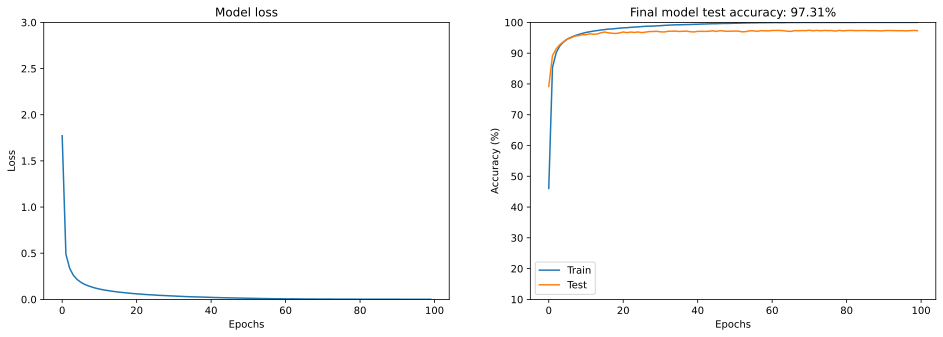

In [31]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

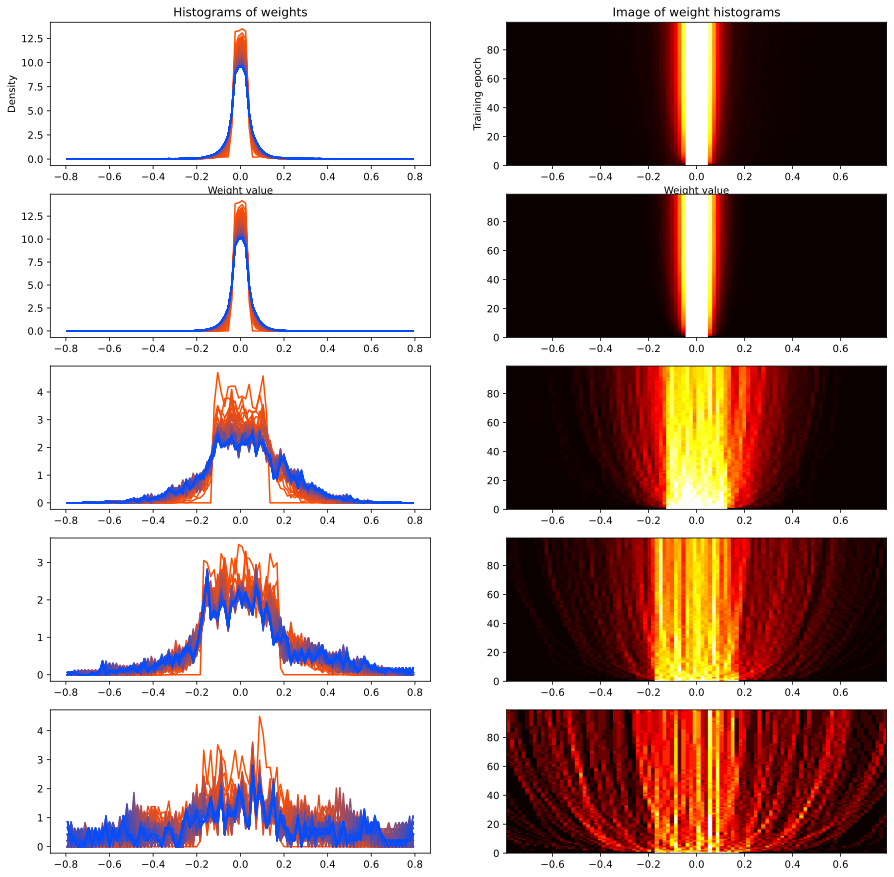

In [32]:
# show the histogram of the weights

fig,ax = plt.subplots(5,2,figsize=(15,15))

for i in range(histy.shape[0]):
  ax[0][0].plot(histx,histy[i,:],color=[1-i/100,.3,i/100]) # Color goes from red to blue
  ax[1][0].plot(histxInput,histyInput[i,:],color=[1-i/100,.3,i/100])
  ax[2][0].plot(histxfc1,histyfc1[i,:],color=[1-i/100,.3,i/100])
  ax[3][0].plot(histxfc2,histyfc2[i,:],color=[1-i/100,.3,i/100])
  ax[4][0].plot(histxOutput,histyOutput[i,:],color=[1-i/100,.3,i/100])

ax[0][0].set_title('Histograms of weights')
ax[0][0].set_xlabel('Weight value')
ax[0][0].set_ylabel('Density')


ax[0][1].imshow(histy,vmin=0,vmax=3,
             extent=[histx[0],histx[-1],0,99],aspect='auto',origin='lower',cmap='hot')
ax[1][1].imshow(histyInput,vmin=0,vmax=3,
             extent=[histxInput[0],histxInput[-1],0,99],aspect='auto',origin='lower',cmap='hot')
ax[2][1].imshow(histyfc1,vmin=0,vmax=3,
             extent=[histxfc1[0],histxfc1[-1],0,99],aspect='auto',origin='lower',cmap='hot')
ax[3][1].imshow(histyfc2,vmin=0,vmax=3,
             extent=[histxfc2[0],histxfc2[-1],0,99],aspect='auto',origin='lower',cmap='hot')
ax[4][1].imshow(histyOutput,vmin=0,vmax=3,
             extent=[histxOutput[0],histxOutput[-1],0,99],aspect='auto',origin='lower',cmap='hot')
ax[0][1].set_xlabel('Weight value')
ax[0][1].set_ylabel('Training epoch')
ax[0][1].set_title('Image of weight histograms')

plt.show()

# Additional explorations

In [ ]:
# 1) Separate the distributions for input, hidden, and output layers. 
#    Are the learning-related changes similar across all layers?
# 
# 2) Re-run the code without data normalization. 
#    Does the scale of the data affect the scale of the weights?
# 
# 3) Test how dropout regularization affects the weight distributions.
# 